In [1]:
%load_ext autoreload

In [2]:
# python -m pip install 'git+https://github.com/MaureenZOU/detectron2-xyz.git'

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append(".")
import os

from utils.logging import CustomLogger
from agents.agents import agent_factory

from executor import SimpleExecutor, LineWiseExecutor

def show_image(image, points=None, mask=None):

    plt.imshow(image)
    plt.axis('off')

    # If mask is provided, overlay it
    if mask is not None:
        colored_mask = np.zeros((*mask.shape, 4))
        default_mask_color = [0.8, 0.8, 0.8, 0.8]
        colored_mask[mask > 0] = default_mask_color
        plt.imshow(colored_mask)

    # If points are provided, convert them from normalized coordinates and plot them
    if points is not None:
        img_height, img_width = np.array(image).shape[:2]
        points = np.array(points)
        points[:, 0] = points[:, 0] * img_width
        points[:, 1] = points[:, 1] * img_height
        plt.scatter(points[:, 0], points[:, 1], c='red', s=50)  # larger circle
        plt.scatter(points[:, 0], points[:, 1], c='yellow', s=30)  # smaller circle inside

    plt.show()


In [3]:
logger = CustomLogger()

In [4]:
from environments.ur5_simulation import UR5SimulationEnv
env = UR5SimulationEnv(logger=logger)
env.setup()

pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1080/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 470.141.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 470.141.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1080/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [5]:
def run_experiment(env, agent, prompt, debug=True):
    print("Image before planning: ")
    image = env.get_image()
    show_image(image)
    plan_result = agent.try_plan(prompt, image)
    print(plan_result)
    print("Annotated image: ")
    show_image(plan_result.annotated_image)
    
    if not plan_result.success:
        return
        
    # executor = LineWiseExecutor(env.get_execution_context(), pause_every_line=True)
    executor = SimpleExecutor(env.get_execution_context())
    # Build a context containing the masks for the plan code to access
    context = {"regions": [mask["segmentation"] for mask in plan_result.masks]}
    executor.execute_plan(plan_result.plan_code, additional_context=context)

    print("After manipulation: ")
    show_image(env.get_image())

    return plan_result

Specify Your task here.

In [6]:
prompt="""Task: Put the red block into the green bowl."""

Image before planning: 


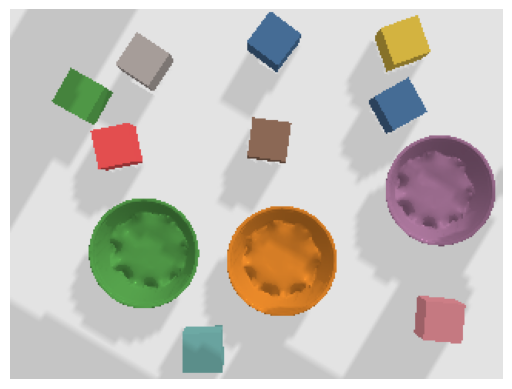

PlanResult(success=True,
 exception=None,
plan_raw="```python\npick(regions[53])\nplace(regions[29], 'inside')\n```",
 masks=[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}],
 prompt='Task: Put the red block into the green bowl.',
 plan_code="\npick(regions[1])\nplace(regions[0], 'inside')\n",
 annotated_image=

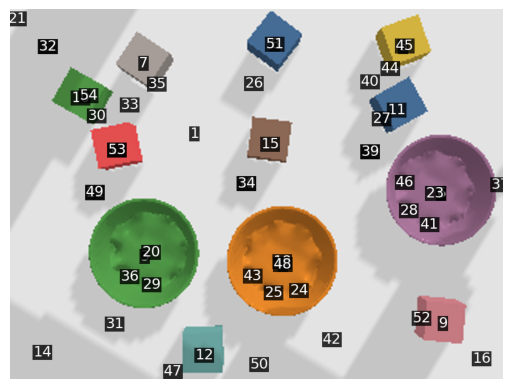

(normalized) Pick:  (0.21453692848769051, 0.371875) , Place:  (0.2813599062133646, 0.7359375)
(pixel) Pick : (68, 89), Place: (90, 176)
After manipulation: 


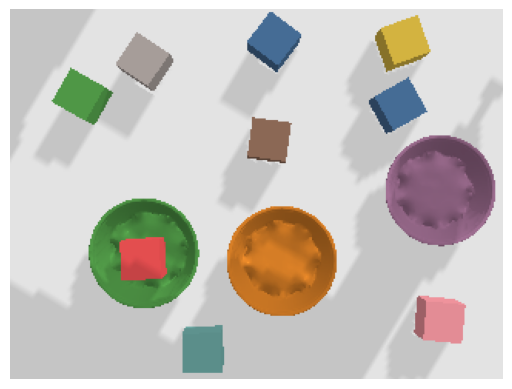

In [7]:
agent = agent_factory("SegVLM", logger=logger)
agent.configs["img_size"] = 640
plan_result = run_experiment(env, agent, prompt)

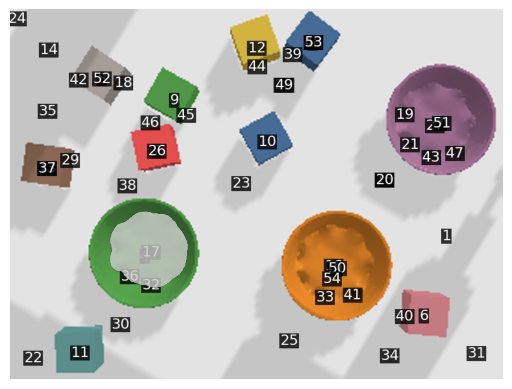

In [10]:
show_image(plan_result.annotated_image, mask=plan_result.masks[0]["segmentation"])

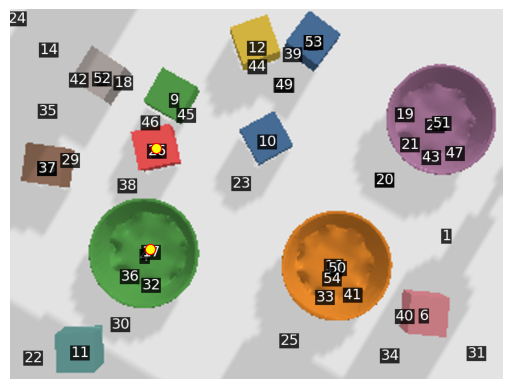

In [11]:
show_image(plan_result.annotated_image, points=[(0.2954279015240328, 0.375), (0.283704572098476, 0.6484375)])

In [7]:
image = env.get_image()
agent = agent_factory("SegVLM")
agent.configs["img_size"] = 640
plan_result = agent.plan(prompt, image)
plan_result

PlanResult(success=True,
 error_message=None,
 plan_raw="```python\npick(regions[13]) # Pick up the red block\nplace(regions[34], 'inside') # Place the red block inside the green bowl\n```",
 masks=[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}],
 prompt='Task: Put the red block into the green bowl.',
 plan_co

Image before planning: 


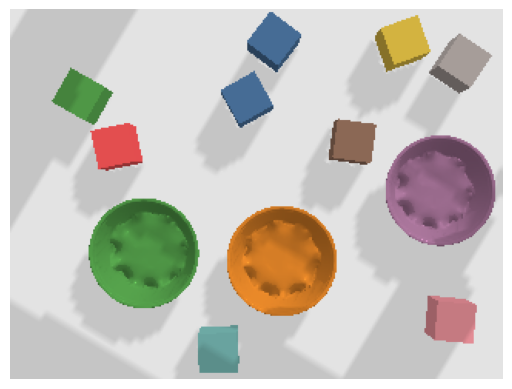

PlanResult(success=True,
 error_message=None,
 plan_raw="```python\npick(regions[7])\nplace(regions[4], 'inside')\n```",
 masks=[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}],
 prompt='Task: Put the red block into the green bowl.',
 plan_code="\npick(regions[1])\nplace(regions[0], 'inside')\n",
 annotated_ima

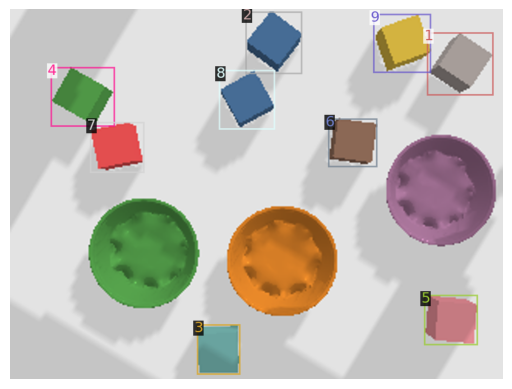

NameError: name 'Executor' is not defined

In [6]:
agent = agent_factory("DetVLM")
agent.configs["img_size"] = 640
plan_result = run_experiment(env, agent, prompt)

Image before planning: 


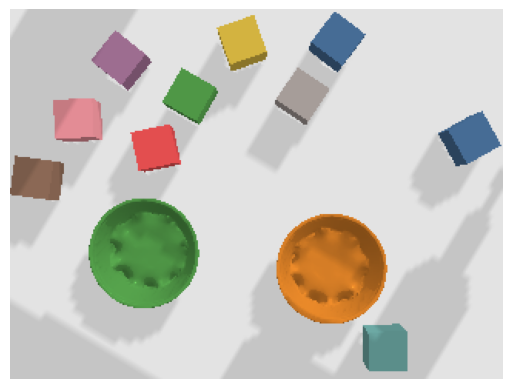

PlanResult(success=True,
 error_message=None,
 plan_raw='```python\n# Plan\n# 1. Pick the block \n# 2. Place the block inside the bowl \n\nblock = "block"\nbowl = "green bowl"\n\n# picking up the block\npick(block)\n\n# placing the block inside the bowl\nplace(block, \'inside\')\n```',
 masks=[],
 prompt='List of objects detected (coordinates are in (x1,y1), (x2, y2) order):\n- block (coordinates: (0.72, 0.85), (0.81, 0.98))\n\nTask: Put the red block into the green bowl.',
 plan_code='\n# Plan\n# 1. Pick the block \n# 2. Place the block inside the bowl \n\nblock = "block"\nbowl = "green bowl"\n\n# picking up the block\npick(block)\n\n# placing the block inside the bowl\nplace(block, \'inside\')\n',
 annotated_image=<PIL.Image.Image image mode=RGB size=853x640 at 0x7FDE540E8550>,
 info_dict={'configs': {'img_size': 640, 'alpha': 0.7, 'include_coordinates': True}, 'detected_objects': [{'score': 0.5527634024620056, 'bbox': [0.7156502306461334, 0.8495150124712381, 0.8084563910961151, 0.98

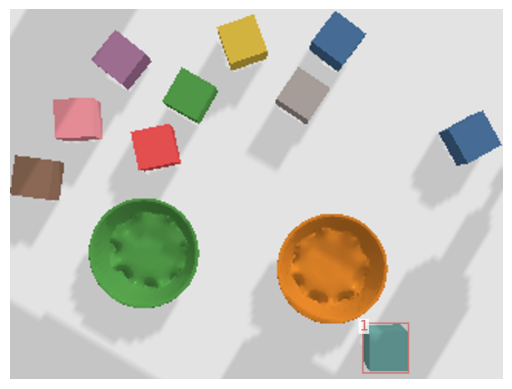

(Executor) Executing line 6: block = "block"
(Executor) Executing line 7: bowl = "green bowl"
(Executor) Executing line 10: pick(block)
(Executor) Executing line 13: place(block, 'inside')


Error on line 13: '>' not supported between instances of 'str' and 'int'


TypeError: '>' not supported between instances of 'str' and 'int'

In [8]:
agent = agent_factory("DetLLM")
agent.configs["img_size"] = 640
plan_result = run_experiment(env, agent, prompt)

Image before planning: 


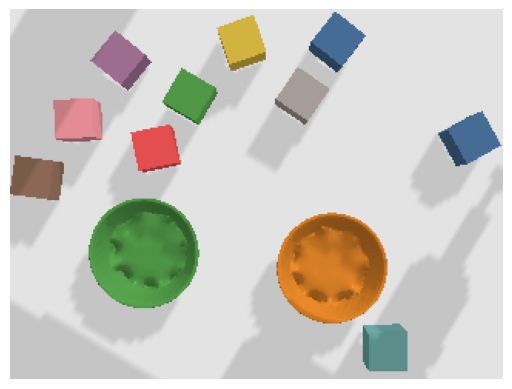

KeyError: '"name"'

In [9]:
agent = agent_factory("VLMDet")
agent.configs["img_size"] = 640
plan_result = run_experiment(env, agent, prompt)

Image before planning: 


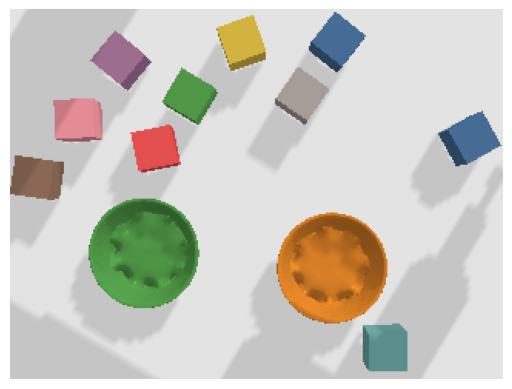

UnboundLocalError: local variable 'objects_of_interest' referenced before assignment

In [10]:
agent = agent_factory("VLMDetInspect")
agent.configs["img_size"] = 640
plan_result = run_experiment(env, agent, prompt)

In [9]:
logger.save_logs_to_html_file("result.html")